# Preambule

In [1]:
library(tidyverse)
library(ggpubr)
library(caret)
library(igraph)
library(ggraph)
library(qs)
library(data.table)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] data.table_1.13.4 qs_0.23.4         ggraph_2.0.4      igraph_1.2.6     
 [5] caret_6.0-86      lattice_0.20-41   ggpubr_0.4.0      forcats_0.5.0    
 [9] stringr_1.4.0     dplyr_1.0.2       purrr_0.3.4       readr_1.4.0      
[13] tidyr_1.1.2       tibble_3.0.4     

# Data

In [3]:
nr <- 1000

In [4]:
# simulate data
simu <- data.table(tmp = 1:nr)

for (j in 1:12){
    set.seed(j)
    set(simu, NULL, paste0('V',j), value = rnorm(nr, mean = .5, sd = 1))
}
simu <- simu[,tmp:=NULL]

set(simu, 1:(0.25*nr), 'target', simu[[1]][ 1:(0.25*nr) ]*simu[[2]][ 1:(0.25*nr) ] )
set(simu, 1:(0.25*nr), 'group', 'a')

set(simu, (0.25*nr+1):(0.5*nr), 'target', simu[[3]][ (0.25*nr+1):(0.5*nr) ])
set(simu, (0.25*nr+1):(0.5*nr), 'group', 'b')

set(simu, (0.5*nr+1):(0.75*nr), 'target', simu[[4]][(0.5*nr+1):(0.75*nr) ]+simu[[5]][ (0.5*nr+1):(0.75*nr) ])
set(simu, (0.5*nr+1):(0.75*nr), 'group', 'c')

set(simu, (0.75*nr+1):nr, 'target', simu[[6]][(0.75*nr+1):nr] - simu[[7]][(0.75*nr+1):nr])
set(simu, (0.75*nr+1):nr, 'group', 'd')

In [5]:
# randomize target labels
set.seed(0)
brnounou <- rbinom(n = nr, size = 1, prob = 0.05)
simu$target[brnounou == 1] <- -simu$target[brnounou == 1]
set(simu, NULL, 'target', as.character(sign(simu[['target']])))

In [6]:
# one plot per observation group
ga <- ggplot(data = simu %>% subset(group == 'a'), aes(x = V1, y = V2, color = target)) + 
theme_classic()+ 
geom_hline(yintercept = 0, color = 'darkgrey')+geom_vline(xintercept = 0, color = 'darkgrey')+
geom_point(alpha = .5, size = 3) +
geom_hline(yintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+
geom_vline(xintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+
scale_color_manual(values = c("#E69F00","#0072B2"), name = 'Target') + 
theme(legend.title=element_text(size=rel(1.2)), legend.text = element_text(size = rel(1.2)) )+
guides(color = guide_legend(override.aes = list(size = 3, alpha = 1)))+
labs(title = 'Group a')

gb <- ggplot(data = simu %>% subset(group == 'b'), aes(x = V3, y = V2, color = target)) + 
theme_classic()+ 
geom_hline(yintercept = 0, color = 'darkgrey')+geom_vline(xintercept = 0, color = 'darkgrey')+
geom_point(alpha = .5, size = 3) +
geom_vline(xintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+
scale_color_manual(values = c("#E69F00","#0072B2")) + 
labs(title = 'Group b')

gc <- ggplot(data = simu %>% subset(group == 'c'), aes(x = V4, y = V5, color = target)) + 
theme_classic()+ 
geom_hline(yintercept = 0, color = 'darkgrey')+geom_vline(xintercept = 0, color = 'darkgrey')+
geom_point(alpha = .5, size = 3) +
geom_hline(yintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+geom_vline(xintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+
scale_color_manual(values = c("#E69F00","#0072B2")) + 
labs(title = 'Group c')

gd <- ggplot(data = simu %>% subset(group == 'd'), aes(x = V6, y = V7, color = target)) + 
theme_classic()+ 
geom_hline(yintercept = 0, color = 'darkgrey')+geom_vline(xintercept = 0, color = 'darkgrey')+
geom_point(alpha = .5, size = 3) +
geom_hline(yintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+geom_vline(xintercept = 0, color = 'dimgrey', size = 1.5, linetype = 'dashed')+
scale_color_manual(values = c("#E69F00","#0072B2")) + 
labs(title = 'Group d')

In [7]:
toydata <- ggarrange(ga, gb,gc, gd
          , labels = c("A", 'B', 'C', 'D')
          , ncol = 4, nrow = 1
          , common.legend = TRUE, legend = "right")

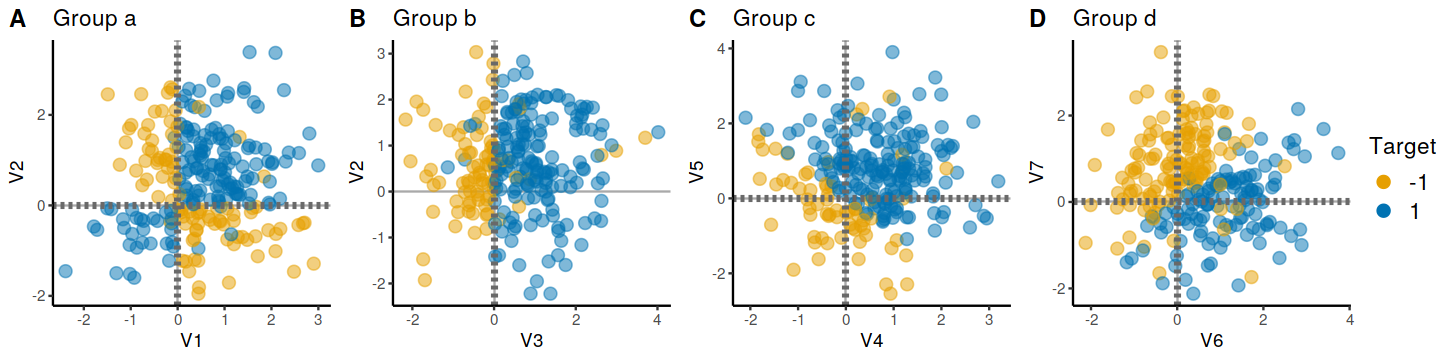

In [8]:
options(repr.plot.width=12, repr.plot.height=3)
toydata

# ground truth network

Hand-written based on the data generation process (see above)

In [9]:
gt_edges<- data.frame(
    'x' = c('V1__High', 'V2__High','V1__High', 'V1__Low', 'V2__Low','V1__Low', 'V1__Low', 'V1__High'
           , 'V3__Low', 'V3__High'
           , 'V4__High', 'V5__High','V4__High', 'V4__Low', 'V5__Low','V4__Low' 
           , 'V6__High', 'V7__High','V6__High', 'V6__Low', 'V7__Low','V6__Low')
    , 'y' = c('Group a','Group a','V2__High','Group a','Group a','V2__Low', 'V2__High','V2__Low'
             , 'Group b','Group b'
             , 'Group c','Group c','V5__High','Group c','Group c','V5__Low'
             ,'Group d','Group d','V7__Low','Group d','Group d','V7__High')
    , 'influence' = c(0.5,0.5,1, -0.5,-0.5,1, -1, -1
                     ,-1, 1
                     , .75,.75, 1, -.75, -.75, -1
                     , .75,  -.75, 1, -.75, .75, -1)
)


In [10]:
gt_nodes <- data.frame(var=unique(c(gt_edges$x, gt_edges$y)))
gt_nodes$influence <- c(0, 0, 0, 0
                        , -1, 1
                        , .75, .75, -.5, -.5
                        , .5, -.5, -.75, .75
                       , 0, 0, 0, 0)

In [11]:
network <- graph_from_data_frame(d = gt_edges, directed = FALSE,vertices = gt_nodes)

In [12]:
net <-  ggraph(network, layout = 'stress') + 
geom_edge_fan(aes(color = influence), width = 1.25)+ 
geom_node_point(aes(fill = influence), color = "black", shape = 21, size =3) + 
geom_node_text(aes(label = name), repel = TRUE, size = 4.5) + 
theme_graph() + 
theme_graph(base_family="sans") +
scale_edge_linetype_manual(values = linetype) + 

scale_edge_colour_gradient2(low = "#E69F00", mid = "grey90", high ="#0072B2", midpoint = 0
                     , limits = c(-1, 1), breaks = c(-.8,0, .8), labels = c('negative','depends', 'positive')) + 

scale_fill_gradient2(low = "#E69F00", mid = "grey90", high ="#0072B2", midpoint = 0
                     , limits = c(-1, 1), breaks = c(-.8,0, .8), labels = c('negative','depends', 'positive'))+

guides(edge_colour = "none")+

theme(legend.position = "right"
      , legend.title=element_text(size=rel(1.2))
      , legend.text = element_text(size = rel(1.2))
      , plot.margin = unit(c(0.2,0.2,0.2,0.2), "cm")
      , plot.title = element_text(size = rel(1.25), face="plain", vjust = .9, hjust = .055)
     ) + 
guides(size = guide_legend(ncol = 6, byrow = T, title.vjust = 0.5) )+
labs(fill = 'Association\nwith target', title = 'Ground truth network')

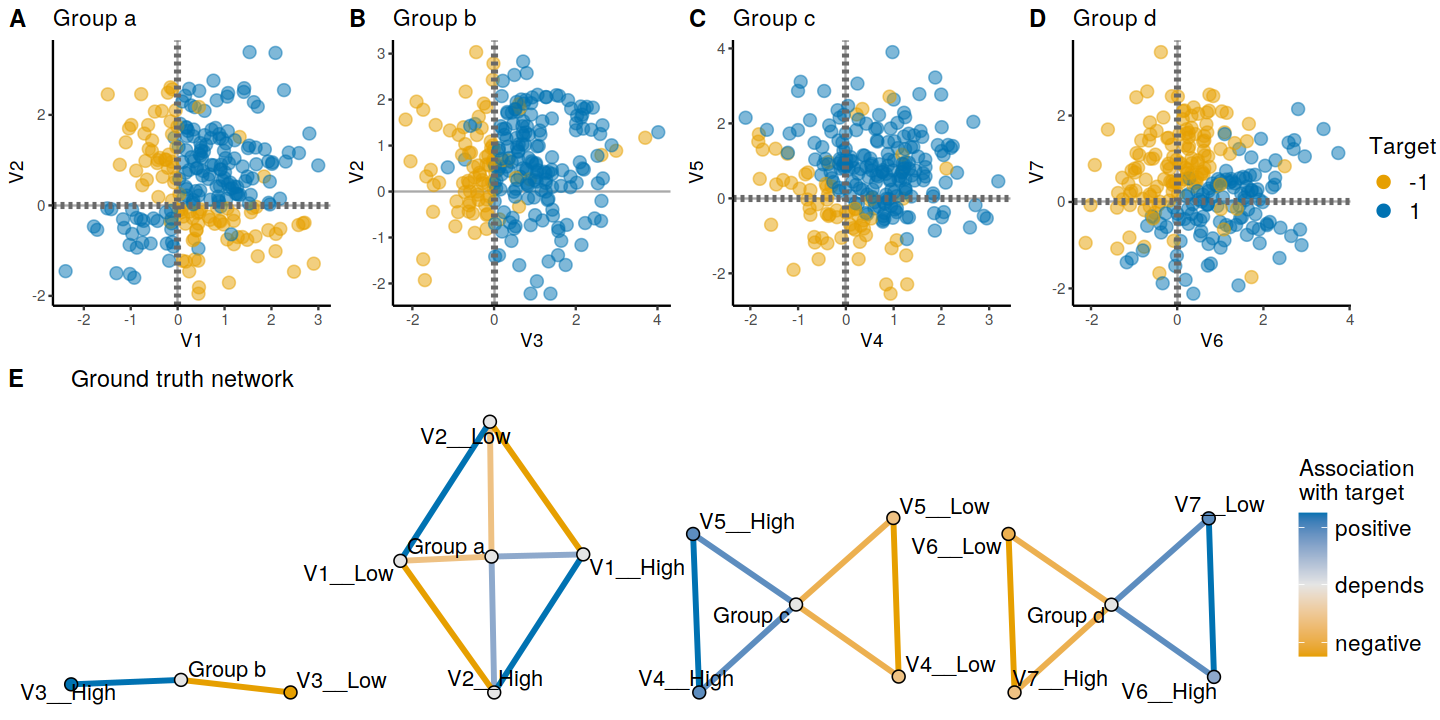

In [13]:
options(repr.plot.width=12, repr.plot.height=6)
ggarrange(toydata, net, ncol = 1, nrow=2, labels = c('', 'E'))